In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Starting project...")
print("Hello, world!")

Starting project...
Hello, world!


In [5]:
data = pd.read_csv("Crimes - 2001 to present (25th mai 2020).csv", dtype=object)

In [6]:
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,false,false,...,8,45,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,false,false,...,21,73,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,false,false,...,18,70,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,false,false,...,20,42,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,false,false,...,42,32,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899981 entries, 0 to 4899980
Data columns (total 22 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    object
 1   Case Number           object
 2   Date                  object
 3   Block                 object
 4   IUCR                  object
 5   Primary Type          object
 6   Description           object
 7   Location Description  object
 8   Arrest                object
 9   Domestic              object
 10  Beat                  object
 11  District              object
 12  Ward                  object
 13  Community Area        object
 14  FBI Code              object
 15  X Coordinate          object
 16  Y Coordinate          object
 17  Year                  object
 18  Updated On            object
 19  Latitude              object
 20  Longitude             object
 21  Location              object
dtypes: object(22)
memory usage: 822.4+ MB


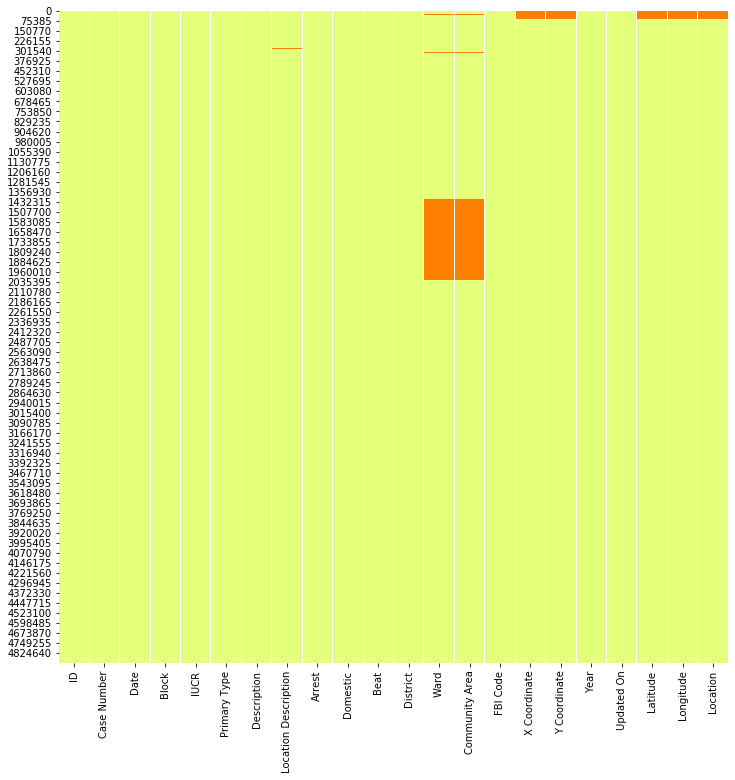

In [9]:
# Visualize how many values are null before engineering
plt.figure(figsize=(12, 12))
sns.heatmap(data.isnull(), cbar=False, cmap='Wistia')

In [23]:
# since the dataset is absolutely immense, we can easily drop the NaN rows
data = data.dropna()

In [24]:
# Feature engineering
# 1. Drop unused tables: ID, Case Number
data.drop(['ID', 'Case Number', 'X Coordinate', 'Y Coordinate', 'Block', 'Updated On'], axis=1)


,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Location
63305,04/10/2019 04:37:00 PM,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,SCHOOL - PUBLIC BUILDING,false,false,0511,005,9,49,17,2019.0,41.708589,-87.612583094,"(41.708589, -87.612583094)"
63389,04/12/2019 04:08:00 PM,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,false,true,1731,017,30,16,02,2019.0,41.940297617,-87.732066473,"(41.940297617, -87.732066473)"
63390,04/19/2019 01:57:00 PM,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,false,true,1532,015,28,25,17,2019.0,41.884865037,-87.755230327,"(41.884865037, -87.755230327)"
63466,04/25/2019 05:20:00 PM,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,false,true,0513,005,9,49,08B,2019.0,41.697609261,-87.613507612,"(41.697609261, -87.613507612)"
63871,05/13/2019 05:26:00 PM,0560,ASSAULT,SIMPLE,STREET,false,false,2222,022,21,73,08A,2019.0,41.729973132,-87.653166753,"(41.729973132, -87.653166753)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4899971,08/18/2008 08:50:46 PM,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,false,false,2532,025,37,25,14,2008.0,41.90812549,-87.764623574,"(41.90812549, -87.764623574)"
4899972,08/19/2008 07:30:00 PM,2820,OTHER OFFENSE,TELEPHONE THREAT,RESIDENCE,false,true,0822,008,14,62,26,2008.0,41.787858625,-87.716346942,"(41.787858625, -87.716346942)"
4899973,08/18/2008 06:00:00 PM,0810,THEFT,OVER $500,STREET,false,false,1633,016,38,15,06,2008.0,41.953109179,-87.772499177,"(41.953109179, -87.772499177)"
4899974,08/18/2008 05:30:00 AM,0915,MOTOR VEHICLE THEFT,"TRUCK, BUS, MOTOR HOME",STREET,false,false,0623,006,6,69,07,2008.0,41.757532586,-87.624742585,"(41.757532586, -87.624742585)"


In [28]:
# Since we loaded the model with object as dtype (for faster loading), 
# we're going to specify all the types manually
data.Year = data['Year'].astype(int)

In [42]:
# We've eliminated 2020 to minimize the risk of possible anomalies happening in 2020 due to Covid-19
data = data[(data.Year > 2000) & (data.Year < 2020)] 

In [64]:
# check to see if we have years from the entire interval
years = data.Year.unique()
years.sort()
print(years)

[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019]


In [70]:
data['Primary Type'].unique()

array(['SEX OFFENSE', 'OFFENSE INVOLVING CHILDREN', 'BATTERY', 'ASSAULT',
       'THEFT', 'STALKING', 'CRIMINAL DAMAGE', 'MOTOR VEHICLE THEFT',
       'OTHER OFFENSE', 'NARCOTICS', 'ROBBERY',
       'INTERFERENCE WITH PUBLIC OFFICER', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'BURGLARY', 'WEAPONS VIOLATION',
       'PROSTITUTION', 'GAMBLING', 'ARSON', 'CRIM SEXUAL ASSAULT',
       'PUBLIC PEACE VIOLATION', 'KIDNAPPING', 'INTIMIDATION',
       'CRIMINAL SEXUAL ASSAULT', 'CONCEALED CARRY LICENSE VIOLATION',
       'LIQUOR LAW VIOLATION', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'OBSCENITY', 'HUMAN TRAFFICKING',
       'HOMICIDE', 'NON-CRIMINAL', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'], dtype=object)